# Australia Rain Prediction

[Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains approximately 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:

![](https://i.imgur.com/5QNJvir.png)

## Problem statement

We want to develop an automated weather prediction system that can accurately forecast whether it will rain tomorrow at specific locations across Australia. 

This system aims to provide valuable information to various stakeholders such as farmers, event planners, and the general public, allowing them to make informed decisions based on expected rainfall.

![](https://i.imgur.com/KWfcpcO.png)


### Table of Contents

* Dataset description
* Problem statement
* Loading data
* Filling missing values
* Numerical features scaling
* Categorical features encoding
* Saving results

### Imports

In [1]:
import opendatasets as od
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


## Loading data

We will use the `opendatasets` library to load data from Kaggle directly into Jupyter.

In [2]:
# define data url and destination path
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
target_dir = 'data/'

In [3]:
isLoaded = True
if not isLoaded: 
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Change to the target directory
    os.chdir(target_dir)
    
    # Download the dataset
    od.download(dataset_url, force=True)

In [4]:
# check that file downloaded
data_dir = target_dir + 'weather-dataset-rattle-package'
# os.chdir('../')
# os.listdir(data_dir)

Load data from `weatherAUS.csv` with Pandas.

In [5]:
train_csv_dir = data_dir + '/weatherAUS.csv'

In [6]:
raw_df = pd.read_csv(train_csv_dir)

In [7]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


The dataset contains over 145,000 rows and 23 columns. The dataset contains columns with dates, numeric values, and categorical values. Our goal is to create a model to predict the value in the `RainTomorrow` column.

Let's check the data types and missing values ​​in different columns.

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Although we should be able to fill in missing values ​​for most columns, it may be worth discarding rows where `RainTomorrow` or `RainToday` values ​​are missing since one is the target variable and the other is probably very closely related to the target variable.

In [9]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [10]:
raw_df.shape

(140787, 23)

## Train/Test split


For the current dataset, we can use the `Date` column in the dataset to create another column for the year.

We will select the last two years for the test set and one year before them for the validation set.

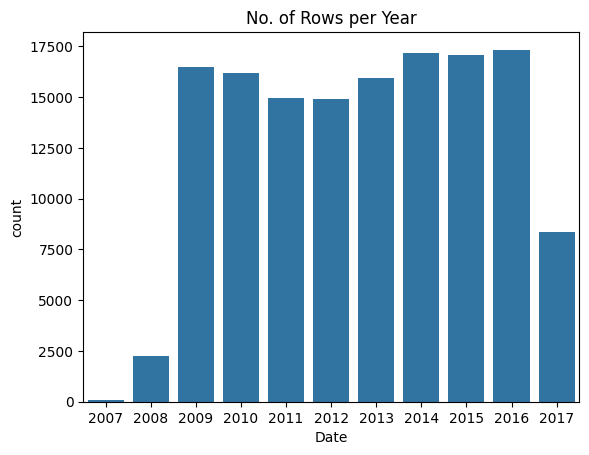

In [11]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [12]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [13]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


## Defining input and target columns

Let's create a list of input columns and define a target column

In [14]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [15]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [16]:
target_col

'RainTomorrow'

We can generate input and target values ​​for the `training`, `validation`, and `test` sets for further processing and model training.

In [17]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [18]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [19]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Now let's also define which of the columns are `numeric` and which are `categorical`. This will be useful later as we will need to convert the categorical data into numbers to train the logistic regression model.

In [20]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [21]:
numeric_cols, categorical_cols

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

Review some statistics for numeric columns

In [22]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.00,97801.00,97988.00,61657.00,57942.00,91160.00,97114.00,96919.00,96936.00,96872.00,88876.00,88857.00,63000.00,61966.00,97414.00,97392.00
mean,12.01,23.02,2.37,5.29,7.61,40.22,14.09,18.76,68.63,51.47,1017.51,1015.13,4.30,4.41,16.84,21.54
std,6.35,6.98,8.52,3.95,3.79,13.70,8.98,8.87,19.00,20.76,7.07,7.00,2.87,2.69,6.40,6.83
min,-8.50,-4.10,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,979.00,0.00,0.00,-5.90,-5.10
25%,7.50,17.90,0.00,2.60,4.80,31.00,7.00,13.00,57.00,37.00,1012.80,1010.40,1.00,2.00,12.20,16.60
50%,11.80,22.40,0.00,4.60,8.50,39.00,13.00,19.00,70.00,52.00,1017.50,1015.10,5.00,5.00,16.60,20.90
75%,16.60,27.90,0.80,7.20,10.60,48.00,19.00,24.00,83.00,66.00,1022.30,1019.90,7.00,7.00,21.40,26.20
max,33.90,48.10,371.00,82.40,14.30,135.00,87.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.10


The number of categories in each of the categorical columns

In [23]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Data Preparation
### Filling in missing numerical data with from `SimpleImputer`

In [24]:
# fill missing values with mean value
imputer = SimpleImputer(strategy = 'mean')

Let's check the number of missing values ​​in each numeric column.

Let's check the number of missing values for `train_inputs`, as we will use it to train imputer

In [25]:
train_inputs[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

In [26]:
imputer.fit(train_inputs[numeric_cols])

SimpleImputer()

In [27]:
list(imputer.statistics_)

[12.0078311526097,
 23.0222022269711,
 2.37293546148508,
 5.289991404057933,
 7.609003831417626,
 40.21587318999561,
 14.09226270156723,
 18.76460755888938,
 68.62874473879673,
 51.46954744404988,
 1017.5137337413925,
 1015.132351891241,
 4.302952380952381,
 4.410676822773779,
 16.835126367873205,
 21.54013779365862]

Now we can fill missing values ​​in the training, testing, and validation datasets using the `transform` method of the `imputer` object.

In [28]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [29]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Numerical features Scaling

The numeric columns in our dataset have different ranges.
Scaling of numerical features ensures that no particular feature has a disproportionate effect on model losses. 

In [30]:
raw_df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale the values ​​to the $(0,1)$ range.

In [31]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

Now we can scale the training, validation, and test sets using the `transform` method of the `scaler` class

In [32]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [33]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00
mean,0.48,0.52,0.01,0.06,0.53,0.27,0.16,0.22,0.69,0.51,0.61,0.60,0.48,0.49,0.49,0.52
std,0.15,0.13,0.02,0.04,0.20,0.10,0.10,0.10,0.19,0.21,0.11,0.11,0.26,0.24,0.14,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.38,0.42,0.00,0.05,0.52,0.19,0.08,0.15,0.57,0.37,0.54,0.53,0.33,0.33,0.39,0.42
50%,0.48,0.51,0.00,0.06,0.53,0.26,0.15,0.22,0.69,0.52,0.61,0.60,0.48,0.49,0.49,0.51
75%,0.59,0.61,0.00,0.07,0.64,0.31,0.22,0.28,0.83,0.65,0.68,0.67,0.67,0.67,0.59,0.61
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Categorical data Encoding with One-hot encoder

Machine learning models can only be trained with numerical data, so we need to convert categorical data into numbers.

We will use `OneHotEncoder` from `sklearn.preprocessing`, which adds a new binary (0/1) column for each unique category of a categorical column

In [34]:
raw_df[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [35]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [36]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [37]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

The encoder created a list of categories for each of the categorical columns in the dataset.

We can generate column names for each individual category using `get_feature_names_out`.

In [38]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

All this columns will be added to `train_inputs`, `val_inputs` and `test_inputs`.

To perform encoding, we use the `transform` method of the `encoder` object.

In [39]:
encoder.transform(train_inputs[categorical_cols])[:10]

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [40]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15880\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15880\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15880\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [41]:
pd.set_option('display.max_columns', None)
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.798851,0.000000,0.064199,0.532098,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.498350,0.777778,0.333333,0.694143,0.816406,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.722222,0.001078,0.064199,0.532098,SSE,0.341085,SSE,SE,0.103448,0.195402,0.54,0.30,0.505785,0.485149,0.888889,0.888889,0.665944,0.718750,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.521073,0.005930,0.064199,0.532098,ENE,0.325581,ESE,ENE,0.126437,0.448276,0.62,0.67,0.553719,0.590759,0.888889,0.888889,0.600868,0.480469,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.532567,0.042049,0.064199,0.532098,SSE,0.255814,SE,SSE,0.103448,0.195402,0.74,0.65,0.618182,0.618812,0.888889,0.888889,0.544469,0.521484,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Let's save the processed data and preprocessing elements to disk to avoid repeating this steps in the future

In [42]:
train_inputs.to_parquet('data/parquet/train_inputs.parquet')
val_inputs.to_parquet('data/parquet/val_inputs.parquet')
test_inputs.to_parquet('data/parquet/test_inputs.parquet')

In [43]:
%%time
pd.DataFrame(train_targets).to_parquet('data/parquet/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('data/parquet/val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('data/parquet/test_targets.parquet')

CPU times: total: 46.9 ms
Wall time: 27 ms


In [46]:
import joblib

aussie_rain = {
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(aussie_rain, 'data/preprocessing.joblib')

['data/preprocessing.joblib']